In [ ]:
import math
import numpy as np
from numpy.linalg import norm
import scipy as sc
from scipy.optimize import fmin
from scipy import optimize

In [ ]:
%pip install numdifftools

## The input functions

In [ ]:
def mxhlib(x_0):
  a = len(x_0+1)
  sum_i = np.zeros(a)
  for i in range(1,a):
    sum_j = 0
    for j in range(1,50):
      sum_j = sum_j+ x_0[i]/(j+i-1)
    sum_i[i]=sum_j
  return max(sum_i)


def maxq(x_0):
  lst = []
  for i in range(0, len(x_0)):
    lst.append((x_0[i])**2)
  return max(lst)

#n is an even pos int
def maxq_x0(n):
  lst = []
  for i in range(1, n//2 +1):
    lst.append(i)
  for i in range(n//2 +1, n+1):
    lst.append(-i)
  return lst

def chained_LQ(x_0):
  max_arr = [0,0]
  for i in range(len(x_0)-1):
    max_arr[0] += -x_0[i]-x_0[i+1]
    max_arr[1] += -x_0[i]-x_0[i+1] + (x_0[i]**2+x_0[i+1]**2-1)
  return max(max_arr)
def chained_Mifflin(x_0):
  sum = 0
  for i in range(len(x_0)-1):
    sum+= -x_0[i]+2*((x_0[i]**2)+(x_0[i+1]**2)-1)+1.75*abs((x_0[i]**2)+(x_0[i+1]**2)-1)
  return sum
# OBjective function definition
def f(x,name="MXHILB"):
  if name == "MXHILB":
    return mxhlib(x)
  elif name == "MAXQ":
    return maxq(x)
  elif name == "ChainedMifflin":
    return chained_Mifflin(x)
  elif name == "LQ":
    return lq(x)
  elif name == "Mifflin":
    return mifflin(x)
  elif name == "ChainedLQ":
    return chained_LQ(x)





## Helper functions

#### Just a note:
From "Gradient Trust Region with limited memory BFGS update for nonsmooth convex minimization" :
For problem min θ(x), we use the function fminsearch of Matlab to get the
solution p(x) and gα(x,ε) is computed by (2.1)

They define θ(z) = f(z) + ||z-x||^2 / 2 * lambda
and p(x) = argmin θ(z)
    * note: p(x) is a vector z in R^n such that it minimizes θ(z)
    
About fminsearch from https://www.mathworks.com/help/matlab/ref/fminsearch.html:
"Find minimum of unconstrained multivariable function using derivative-free method"
"Nonlinear programming solver. Searches for the minimum of a problem specified by
min_x f(x), where f(x) is a function that returns a scalar, and x is a vector or a matrix."


An option for python (I think it's the same?): https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html
fmin(func, x_0, xtol, ftol) (i forget which tol we're using)



In [ ]:
def objF(x, lam, x_k):
    return f(x)+(1/(lam*2))*(norm(x-x_k))**2

def Fer(x,x_k,e_k,lam):
    return f(x,"ChainedLQ")+(1/(2*lam))*(norm(x-x_k))**2 + e_k

def regularized_f(x,x_k,e_k=0.025,lam=1):
    return f(x,"ChainedMifflin")+(1/(2*lam))*(norm(x-x_k))**2 + e_k

#function finding p alpha for a given er, lam and the previously found minimizer, z = x_(k-1)
#method Nelder-Mead is used
#I think a generic x0 can be used each time
def pal(x,x_k, e_k, lam):
    res = optimize.minimize(Fer, x, args=(x_k,e_k,lam), method = 'Nelder-Mead')
    pax = res.x
    return pax

#Solve simplex unconstrained
def f_simplex(x_0):
  result = optimize.minimize(regularized_f, x_0,args=(x_0), method="CG", tol=0.00000000001, options= {"maxiter":100})
  print("RESULT", result)
  pax = result.x
  return pax

#note: e_k is an input in the paper's code
def error_k(k):
    e_k = 1 / ((k + 2) ** 2)

    return e_k


def g(x_k, e_k, lam):
    return (x_k - pal(x_k, e_k)) / lam

def g_alpha(x,x_k, e_k, lam):
  return (x_k - pal(x,x_k, e_k,lam)) / lam

def F(x_k, e_k, lam):
    return f(pal(x_k,x_k, e_k, lam)) + ((norm(pal(x_k,x_k, e_k, lam) - x_k)) ** 2) / 2 * lam


#determining stepsize a_k
def line_search(x_k, d_ki, sigma, beta, tau, gamma, e_k, k, theta_k, g_k, lam,D_k):
    if k == 0:
        D_k.append( F(x_k, e_k, lam) )

    else:
        D_k.append( theta_k * (D_k[k-1] + error_k(k - 1)) + (1 - theta_k) * F(x_k, gamma * error_k(k - 1),lam) )

    a_k = tau
    while F(x_k + a_k * d_ki, gamma * e_k,lam) > D_k[k] + sigma * a_k * calculate_scalar(g_k, d_ki) + e_k:
            a_k = a_k * beta

    return a_k
# TODO: Replace g_k with array of approximations at k using p_x
# Calculate Search direction, d_k, lam_k
def d_ki(k,m, g_k,rho, x_k, e_k, lam, x,prev_dki):
  if k<= m:
    return -g_k
  else:
    d_k = calculate_lambda_ki(g_k,prev_dki,k,m,rho)
    return d_k

def calculate_lambda_ki(g_k,prev_dki,k,m,rho):
  sum = 0
  prev = 0
  lam_dk = np.zeros(len(g_k))
  if k-m<=m:
    lambda_k = [0]*(k-m)
    prev = k-m
  else:
    lambda_k = [0]*m
    prev = m
  for j in range(len(lambda_k)):
    lambda_k[j] = rho / m * (norm(g_k) ** 2) / ((norm(g_k) ** 2) + abs(calculate_scalar(g_k , prev_dki[j])))
    lam_dk += lam_d_sum(lambda_k[j],prev_dki[j])
    sum += lambda_k[j]
  lambda_= 1 - sum
  d_k = -lambda_*g_k-lam_dk
  return d_k

 # Gets Sum of vector multiplication
def calculate_scalar(g_k,prev_dki):
  sum = 0
  for i in range(len(g_k)):
    sum += g_k[i]+prev_dki[i]
  return sum

# calculates one vector coresponding to sum of lambda times previous dki's
def lam_d_sum(lambdas,d_ki):
    return np.multiply(d_ki,lambdas)


## MG Method

In [ ]:
def MG_mthd(x_0, rho, tau, sigma, beta, gamma, m, theta_k, lam):
    k = 0
    epsilon = error_k(k)
    e_k = gamma * error_k(-1)
    x_k = x_0
    g_k = (x_k - pal(x_0,x_k, e_k, lam)) / lam
    D_K = []
    prev_dki = []
    if float(norm(g_k)) <= epsilon:
        return x_k

    while norm(g_k) > epsilon:
      #def d_ki(k,m, g_k,rho, x_k, e_k, lam, x):
        d_k = d_ki(k,m,g_k,rho,x_k,e_k,lam,x_0,prev_dki)
        if k>=m:
          if len(prev_dki)<m:
            prev_dki.append(d_k)
          elif len(prev_dki)>=m:
            prev_dki.pop() ## remove first value in list i.e.: d_k-(m+1)
            prev_dki.append(d_k) ## adds more recent one

        a_k = line_search(x_k, d_k, sigma, beta, tau, gamma, e_k, k, theta_k, g_k, lam,D_K)
        x_0 = x_k
        x_k = x_k + a_k * d_k

        while e_k > ((a_k)**2) * ((norm(d_k))**2):
            e_k = e_k / 2

        e_k = error_k(k + 1)
        k = k + 1

        g_k = g_alpha(x_0,x_k, e_k, lam)
        if k % 25 ==0:
          print(" New k ",k," new m ", m," new g_k ",g_k," rho ",rho," e_k ",e_k," lam ",lam," x_0 ",x_0)
    return f(x_k)
x_0 = np.ones(10)
MG_mthd(x_0, 0.001,1,0.01,0.5,0.85,2,0.5,1)

0.0004987571583807474

### Conjugate Gradient Optimal Step Method

In [ ]:
#Need to modify to use Moreau-Yosida regularization and approx p_alpha
#assuming g is a differentiable objective function

import numdifftools as nd
from scipy.optimize import line_search

def FR_CG_method(x_0, tol, N):
    f_3 = lambda x: f(x,"ChainedLQ")
    grad = nd.Gradient(f_3)
    x = list(x_0)
    z = -grad(x)

    k=0

    while k <= N:
        alpha = sc.optimize.line_search(f_3, grad, x, z)[0]

        X = x
        x  = x + alpha * z
        x_list = list(x)
        beta = (norm(grad(x_list)))**2 / (norm(nd.Gradient(F(x_list,tol,1))(X)))**2

        z = -nd.Gradient(f_3)*(x_list) + beta * z
        k+=1
        print(" K: ",k," F:",f_3(x_list))
        if norm(nd.Gradient(f_3)*(x_list)) < tol:
            return x_list, f(x_list)

    return('max it number exceeded')


x_0 = np.ones(1000)

FR_CG_method(x_0,0.001,50)



ModuleNotFoundError: ignored

In [ ]:
#Simplex Solutions

def run():
  x_0 = -1*np.ones(20)
  print("x_0 ",x_0)
  result = f_simplex(x_0)
  print(result)

run()

x_0  [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]
RESULT      fun: 4.941666666666686
     jac: array([ 2.38418579e-07,  1.19209290e-07,  3.57627869e-07,  1.19209290e-07,
        3.57627869e-07,  1.19209290e-07,  3.57627869e-07,  1.19209290e-07,
        3.57627869e-07,  0.00000000e+00,  3.57627869e-07,  1.19209290e-07,
        3.57627869e-07,  1.19209290e-07,  3.57627869e-07,  1.19209290e-07,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.78813934e-07])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 2473
     nit: 7
    njev: 117
  status: 2
 success: False
       x: array([ 3.03039167e-08,  4.09876189e-08,  4.11968571e-08,  4.11968571e-08,
        4.11968571e-08,  4.11968571e-08,  4.11968571e-08,  4.11968571e-08,
        4.78872470e-08,  2.19134693e-08,  3.20817086e-08,  2.19134693e-08,
        2.79490501e-08,  2.19134693e-08,  3.20817086e-08,  2.21227076e-08,
       -7.89693269e-09,  1.11359668e-0

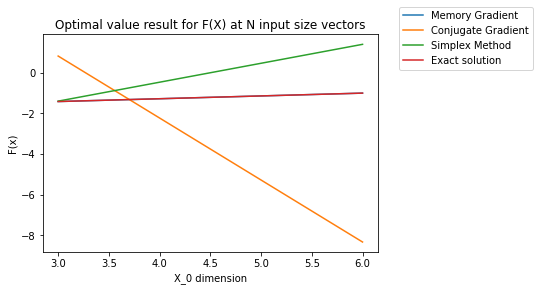

In [ ]:
# plot results
import matplotlib.pyplot as plt

memory_CG_pb1 = [-1.4142,-1.0000 ]
memory_CG_pb3 = [28.4272, ]
memory_CG_pb6 = [28.4272 ,28.3831 ]

conjugate_gradient_pb1 = [0.8237,-8.3245]
conjugate_gradient_pb6 = [114.6783,112.8467 ]
conjugate_gradient_pb3 = []

simplex_pb1 = [-1.3941,1.4000  ]
simplex_pb3 = [307.8883,256.1166 ]
simplex_pb6 = []

expected_pb1 = [-1.4142, -1 ]
expected_pb3 = [0,0]
#'''
plt.plot([3,6],memory_CG_pb1, label="Memory Gradient")
plt.plot([3,6],conjugate_gradient_pb1, label = "Conjugate Gradient")
plt.plot([3,6],simplex_pb1, label = "Simplex Method")
plt.plot([3,6],expected_pb1, label = "Exact solution")
plt.xlabel('X_0 dimension')#'''
'''
plt.plot([20,40],memory_CG_pb6, label="Memory Gradient")
plt.plot([20,40],conjugate_gradient_pb6, label = "Conjugate Gradient")
plt.plot([20,40],simplex_pb3, label = "Simplex Method")
plt.plot([20,40],expected_pb3, label = "Exact solution")
plt.xlabel('X_0 dimension')'''
# Set the y axis label of the current axis.
plt.ylabel('F(x)')
# Set a title of the current axes.
plt.title('Optimal value result for F(X) at N input size vectors')
# show a legend on the plot
plt.legend(bbox_to_anchor =(1.05, 1.15),)
# Display a figure.
plt.show()

# Nonlinear CG Method using Moreau-Yosida Regularization


In [ ]:

'''
Algorithm 1.2.1. (CG method).
Assumptions: ε<0 and x0∈ℝn . Let k=0 , t0=0 , d−1=0 , d0=−g0 , β−1=0 , and β0=0 .

Step 1. If ∥gk∥≤ε , then STOP.
Step 2. Calculate the step-size tk by a line search.
Step 3. Calculate βk by any of the conjugate gradient method.
Step 4. Calculate dk=−gk+βk−1dk−1 .
Step 5. Set xk+1=xk+tkdk .

Step 6. Set k=k+1 and go to Step 1.'''
def conjugate_gradient_unconstrained(x_0,f):
  g_k = nd.Gradient(f)
  x = x_0
  z = -grad(x)
  if float(norm(g_k)) <= epsilon:
    return g_k, f(x_k)
  else:
    dk = -grad(x)

    k=0

    while k <= N:
        alpha = sc.optimize.line_search(f, grad, x, dk)[0]

        X = x
        x  = x + alpha * dk

        beta = (norm(grad(x)))**2 / (norm(nd.Gradient(f)(X)))**2

        z = -nd.Gradient(f)(x) + beta * z
        k+=1
        if norm(nd.Gradient(f)(x)) < tol:
            return x, f(x)
